In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import shap

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Step 1: Load the dataset
data = pd.read_csv("pirate_attacks.csv")

In [ ]:
# Step 2: Convert 'date' to datetime format
data['date'] = pd.to_datetime(data['date'])

In [ ]:
# Step 3: Sort the dataset by date
data = data.sort_values(by='date')

Class distribution after balancing:
target
1    3673
0    3673
Name: count, dtype: int64

Training and evaluating model: Random Forest
Model: Random Forest
Accuracy: 0.8336
AUC: 0.9025

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1584
           1       0.71      0.74      0.72       670

    accuracy                           0.83      2254
   macro avg       0.80      0.81      0.80      2254
weighted avg       0.84      0.83      0.83      2254


Training and evaluating model: Gradient Boosting
Model: Gradient Boosting
Accuracy: 0.7702
AUC: 0.8510

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.77      0.82      1584
           1       0.59      0.77      0.67       670

    accuracy                           0.77      2254
   macro avg       0.74      0.77      0.75      2254
weighted avg       0.80      0.77      0.78      2254


Training

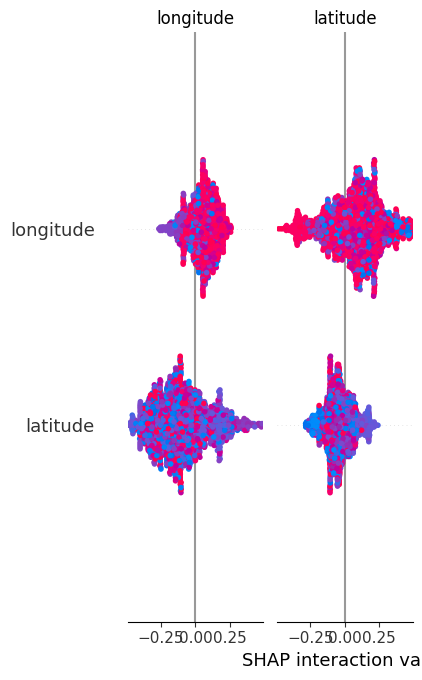

In [ ]:
# Step 4: Calculate the split index for the last 30% (testing data)
split_index = int(len(data) * 0.7)

# Step 5: Define 'future_risk' and 'target'
data['future_risk'] = 0
data.loc[split_index:, 'future_risk'] = 1
data['target'] = data['future_risk']

# Step 6: Feature engineering
# Encode categorical columns
data['attack_type_encoded'] = data['attack_type'].astype('category').cat.codes
data['nearest_country_encoded'] = data['nearest_country'].astype('category').cat.codes

# Create region feature
data['region'] = (data['longitude'] // 1) * 100 + (data['latitude'] // 1)

# Scale numerical features
scaler = StandardScaler()
data[['longitude', 'latitude', 'shore_distance']] = scaler.fit_transform(
    data[['longitude', 'latitude', 'shore_distance']]
)

# Define features and target
X = data[['longitude', 'latitude', 'shore_distance', 'attack_type_encoded', 'nearest_country_encoded', 'region']]
y = data['target']

# Step 7: Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 8: Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Verify class distribution after SMOTE
print("Class distribution after balancing:")
print(y_train_balanced.value_counts())

# Step 9: Define models
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    # Define models
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    }

    results = []

    for name, model in models.items():
        print(f"\nTraining and evaluating model: {name}")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A"

        # Print individual results
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        if y_proba is not None:
            print(f"AUC: {auc:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Append results
        results.append({"Model": name, "Accuracy": accuracy, "AUC": auc})

    # Summary of results
    results_df = pd.DataFrame(results)
    print("\nSummary of Results:")
    print(results_df)
    return results_df

# Train and evaluate models
results_df = train_and_evaluate_models(X_train_balanced, X_test, y_train_balanced, y_test)

# Step 10: Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_balanced, y_train_balanced)

# Print best parameters and score
print("Best Parameters for Random Forest:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Step 11: Ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss'))
], voting='soft')
ensemble_model.fit(X_train_balanced, y_train_balanced)

# Evaluate ensemble model
y_pred_ensemble = ensemble_model.predict(X_test)
y_proba_ensemble = ensemble_model.predict_proba(X_test)[:, 1]
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
auc_ensemble = roc_auc_score(y_test, y_proba_ensemble)

print("\nEnsemble Model Results:")
print(f"Accuracy: {accuracy_ensemble:.4f}")
print(f"AUC: {auc_ensemble:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble))

# Step 12: Analyze feature importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)
feature_importances = rf_model.feature_importances_

print("\nFeature Importances:")
for name, importance in zip(X.columns, feature_importances):
    print(f"{name}: {importance:.4f}")

# Step 13: SHAP for explainability
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
# Save the DataFrame to a CSV file
data.to_csv("finalised_pirate_attacks.csv", index=False)

In [ ]:
from google.colab import files

# Download the CSV file to your computer
files.download("finalised_pirate_attacks.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

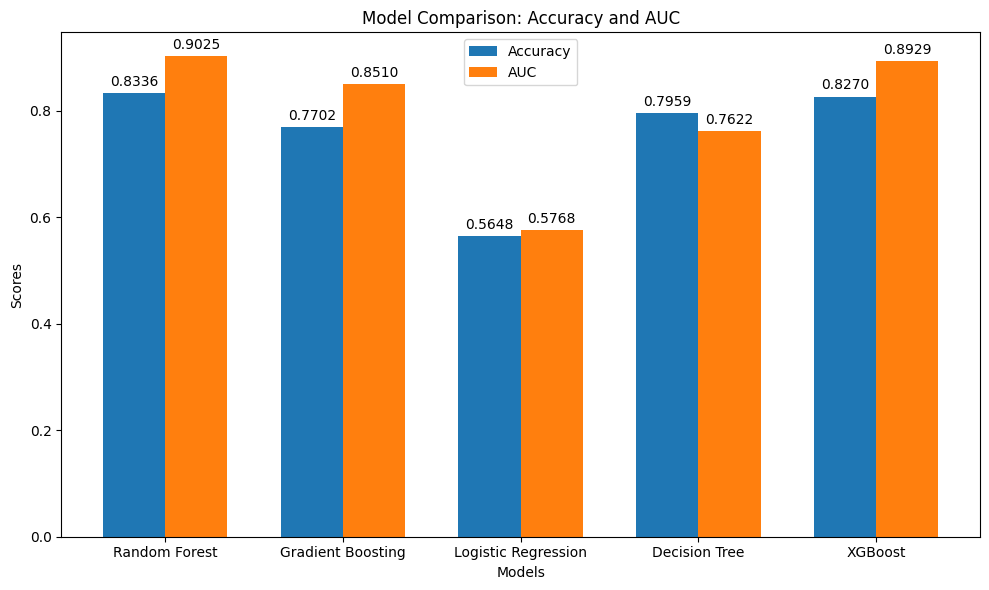

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example model performance data
model_results = {
    "Model": ["Random Forest", "Gradient Boosting", "Logistic Regression", "Decision Tree", "XGBoost"],
    "Accuracy": [0.8336, 0.7702, 0.5648, 0.7959, 0.8270],
    "AUC": [0.9025, 0.8510, 0.5768, 0.7622, 0.8929]
}

# Convert dictionary to a DataFrame
import pandas as pd
results_df = pd.DataFrame(model_results)

# Plot Accuracy and AUC
x = np.arange(len(results_df["Model"]))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, results_df["Accuracy"], width, label='Accuracy')
bars2 = ax.bar(x + width/2, results_df["AUC"], width, label='AUC')

# Add labels, title, and legend
ax.set_xlabel("Models")
ax.set_ylabel("Scores")
ax.set_title("Model Comparison: Accuracy and AUC")
ax.set_xticks(x)
ax.set_xticklabels(results_df["Model"])
ax.legend()

# Annotate bars with values
for bars in [bars1, bars2]:
    ax.bar_label(bars, fmt="%.4f", padding=3)

plt.tight_layout()
plt.show()


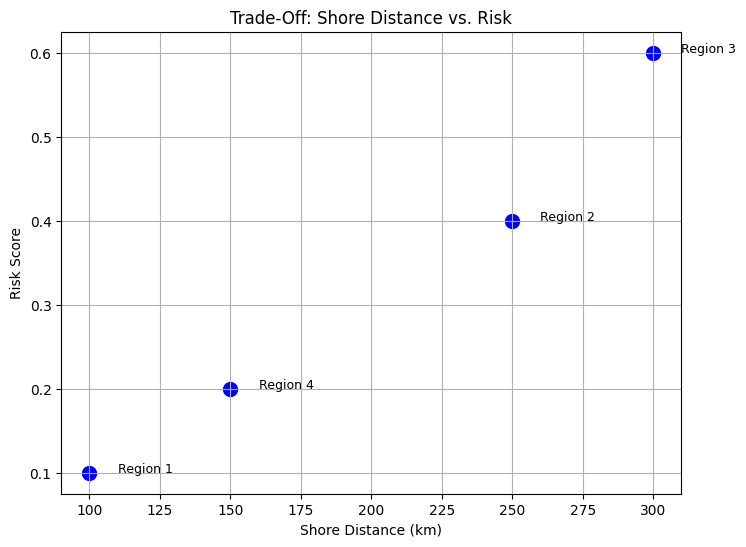

In [ ]:
import matplotlib.pyplot as plt

# Example data for routes or regions
regions = ["Region 1", "Region 2", "Region 3", "Region 4"]
risk = [0.1, 0.4, 0.6, 0.2]  # Risk scores (normalized between 0 and 1)
shore_distance = [100, 250, 300, 150]  # Shore distances in km

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(shore_distance, risk, color='blue', s=100)

# Annotate each point with the region name
for i, region in enumerate(regions):
    plt.text(shore_distance[i] + 10, risk[i], region, fontsize=9)

plt.xlabel("Shore Distance (km)")
plt.ylabel("Risk Score")
plt.title("Trade-Off: Shore Distance vs. Risk")
plt.grid(True)
plt.show()
